A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas LukoÅ¡eviÄius 2012-2018

In [20]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [21]:
from matplotlib import rcParams
COLOR = 'white'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

In [22]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = loadtxt('MackeyGlass_t17.txt')

In [32]:
data.shape

(10000,)

Text(0.5,1,'A sample of data')

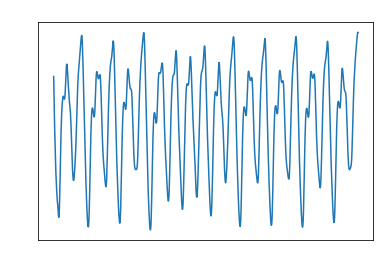

In [24]:
# plot some of it
figure(10).clear()
plot(data[0:1000])
title('A sample of data')

In [25]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 100
a = 0.3 # leaking rate
random.seed(42)
Win = (random.rand(resSize,1+inSize)-0.5) * 1
W = random.rand(resSize,resSize)-0.5 
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Computing spectral radius...
done.


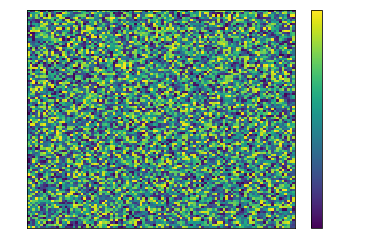

In [26]:
imshow(W, aspect='auto')
colorbar()

In [27]:
# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1] 

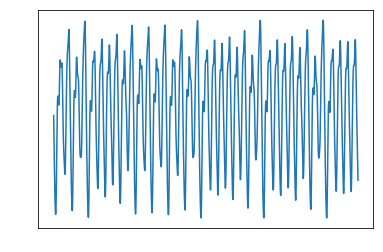

In [40]:
plot(Yt[0])

In [9]:
# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]

In [29]:
u = data[0]
vstack((1,u))

array([[1.      ],
       [0.122064]])

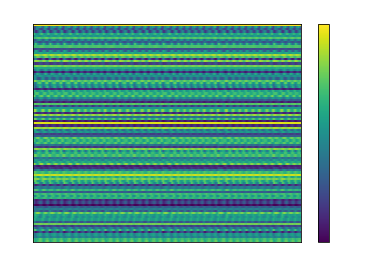

In [21]:
title('Reservoir activations $\mathbf{x}(n)$')
imshow(X, aspect='auto')
colorbar()

In [43]:
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )

In [44]:
X_T.shape

(1900, 102)

In [45]:
Yt.shape

(1, 1900)

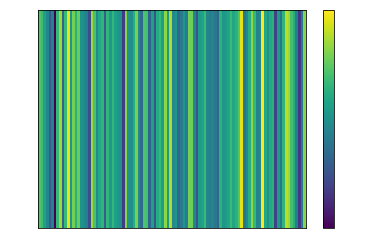

In [12]:
imshow(Wout, aspect='auto')
colorbar()

Text(0.5,1,'Output weights $\\mathbf{W}^{out}$')

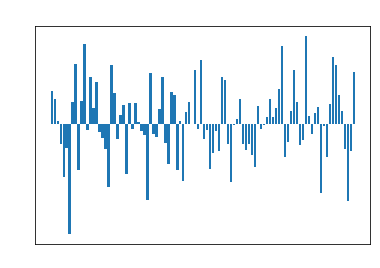

In [13]:
bar( range(1+inSize+resSize), [v[0] for v in Wout.T] )
title('Output weights $\mathbf{W}^{out}$')

In [14]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = zeros((outSize,testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    y = dot( Wout, vstack((1,u,x)) )
    Y[:,t] = y
    # generative mode:
    u = y
    ## this would be a predictive mode:
    #u = data[trainLen+t+1] 


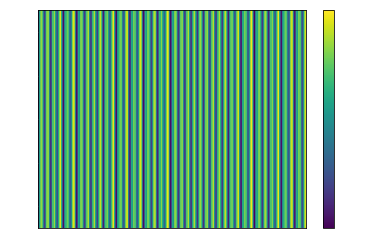

In [15]:
imshow(Y, aspect='auto')
colorbar()

In [16]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = 0.001610553288608649


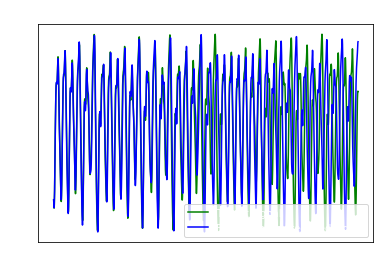

In [17]:
# plot some signals
figure(1).clear()
plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y.T, 'b' )
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])